## Custom tweets Positive/Negative Score Prediction Model

### This model assembled, trained and verified on Google Colab environment due to computation performance limitations on a local machine

In [1]:
# Utilities
import re
import pickle
import numpy as np
import pandas as pd

# Plot libraries
import seaborn as sns
from wordcloud import WordCloud
import matplotlib.pyplot as plt

# Text Processing Libraries
from sklearn.model_selection import train_test_split
from gensim.models import Word2Vec
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Bidirectional, GlobalMaxPool1D, Dense, LSTM, Conv1D, Embedding
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping

In [1]:
# Mounting Google Drive to access work directory (identity authentification is required)

In [2]:
from google.colab import drive 
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
# Retrieving DataSet from Google Drive.
# Alternatively DataSet can be donwloaded here https://www.kaggle.com/ferno2/training1600000processednoemoticoncsv?select=training.1600000.processed.noemoticon.csv

In [3]:
DATASET_COLUMNS  = ["sentiment", "ids", "date", "flag", "user", "text"]
DATASET_ENCODING = "ISO-8859-1"
dataset = pd.read_csv('drive/My Drive/Model1/training.1600000.processed.noemoticon.csv',
                      encoding=DATASET_ENCODING , names=DATASET_COLUMNS)
dataset.head()

,sentiment,ids,date,flag,user,text
0,0,1467810369,Mon Apr 06 22:19:45 PDT 2009,NO_QUERY,_TheSpecialOne_,"@switchfoot http://twitpic.com/2y1zl - Awww, t..."
1,0,1467810672,Mon Apr 06 22:19:49 PDT 2009,NO_QUERY,scotthamilton,is upset that he can't update his Facebook by ...
2,0,1467810917,Mon Apr 06 22:19:53 PDT 2009,NO_QUERY,mattycus,@Kenichan I dived many times for the ball. Man...
3,0,1467811184,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,ElleCTF,my whole body feels itchy and like its on fire
4,0,1467811193,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,Karoli,"@nationwideclass no, it's not behaving at all...."


In [4]:
# Removing the unnecessary columns and replacing the values for sentiment column

In [4]:
dataset = dataset[['sentiment','text']]
dataset['sentiment'] = dataset['sentiment'].replace(4,1)

In [5]:
# Plotting positive vs negative tweets distribution in the dataset

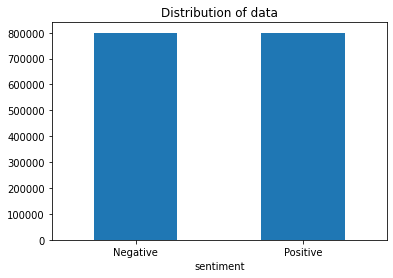

In [5]:
ax = dataset.groupby('sentiment').count().plot(kind='bar', title='Distribution of data',
                                               legend=False)
ax = ax.set_xticklabels(['Negative','Positive'], rotation=0)

In [6]:
# Reading eng_contractions.csv and storing it as a dict. This file used to define meaning of short-cut words
contractions = pd.read_csv('drive/My Drive/Model1/eng_contractions.csv')
contractions.index = contractions.index.str.lower()
contractions.Meaning = contractions.Meaning.str.lower()
contractions_dict = contractions.to_dict()['Meaning']

# Cleaning-up links, usernames and 3+ consecutive letters
urlPattern        = r"((http://)[^ ]*|(https://)[^ ]*|(www\.)[^ ]*)"
userPattern       = '@[^\s]+'
hashtagPattern    = '#[^\s]+'
alphaPattern      = "[^a-z0-9<>]"
sequencePattern   = r"(.)\1\1+"
seqReplacePattern = r"\1\1"

# Emojis meanings
smileemoji        = r"[8:=;]['`\-]?[)d]+"
sademoji          = r"[8:=;]['`\-]?\(+"
neutralemoji      = r"[8:=;]['`\-]?[\/|l*]"
lolemoji          = r"[8:=;]['`\-]?p+"

def preprocess_apply(tweet):

    tweet = tweet.lower()

    # Replace all URls with '<url>'
    tweet = re.sub(urlPattern,'<url>',tweet)
    
    # Replace @USERNAME to '<user>'.
    tweet = re.sub(userPattern,'<user>', tweet)
    
    # Replace 3 or more consecutive letters by 2 letter.
    tweet = re.sub(sequencePattern, seqReplacePattern, tweet)

    # Replace all emojis.
    tweet = re.sub(r'<3', '<heart>', tweet)
    tweet = re.sub(smileemoji, '<smile>', tweet)
    tweet = re.sub(sademoji, '<sadface>', tweet)
    tweet = re.sub(neutralemoji, '<neutralface>', tweet)
    tweet = re.sub(lolemoji, '<lolface>', tweet)

    for contraction, replacement in contractions_dict.items():
        tweet = tweet.replace(contraction, replacement)

    # Remove non-alphanumeric and symbols
    tweet = re.sub(alphaPattern, ' ', tweet)

    # Adding space on either side of '/' to seperate words (After replacing URLS).
    tweet = re.sub(r'/', ' / ', tweet)
    return tweet

In [6]:
# Cleaning-up entire tweet text in the dataset

In [7]:
%%time
dataset['processed_text'] = dataset.text.apply(preprocess_apply)

CPU times: user 1min 30s, sys: 187 ms, total: 1min 30s
Wall time: 1min 30s


In [7]:
# Original vs processed text

In [8]:
count=0
for row in dataset.itertuples():
    print("Text:", row[2])
    print("Processed:", row[3])
    count+=1
    if count>10:
        break

Text: @switchfoot http://twitpic.com/2y1zl - Awww, that's a bummer.  You shoulda got David Carr of Third Day to do it. ;D
Processed: <user> <url>   aww  thatis a bummer   you shoulda got david carr of third day to do it  <smile>
Text: is upset that he can't update his Facebook by texting it... and might cry as a result  School today also. Blah!
Processed: is upset that he cannot update his facebook by texting it   and might cry as a result  school today also  blah 
Text: @Kenichan I dived many times for the ball. Managed to save 50%  The rest go out of bounds
Processed: <user> i dived many times for the ball  managed to save 50   the rest go out of bounds
Text: my whole body feels itchy and like its on fire 
Processed: my whole body feels itchy and like its on fire 
Text: @nationwideclass no, it's not behaving at all. i'm mad. why am i here? because I can't see you all over there. 
Processed: <user> no  it is not behaving at all  i am mad  why am i here  because i cannot see you all ov

In [9]:
processedtext = list(dataset['processed_text'])
data_pos = processedtext[800000:]
data_neg = processedtext[:800000]

In [10]:
# wc = WordCloud(max_words = 1000 , width = 1600 , height = 800,
#               collocations=False).generate(" ".join(data_pos))
# plt.figure(figsize = (20,20))
# plt.imshow(wc)

In [11]:
# wc = WordCloud(max_words = 1000 , width = 1600 , height = 800,
#                collocations=False).generate(" ".join(data_neg))
# plt.figure(figsize = (20,20))
# plt.imshow(wc)

In [12]:
X_data, y_data = np.array(dataset['processed_text']), np.array(dataset['sentiment'])

X_train, X_test, y_train, y_test = train_test_split(X_data, y_data,
                                                    test_size = 0.05, random_state = 0)
print('Data Split done.')

Data Split done.


In [13]:
Embedding_dimensions = 100

# Creating Word2Vec training dataset.
Word2vec_train_data = list(map(lambda x: x.split(), X_train))

In [14]:
%%time

# Defining the model and training it.
word2vec_model = Word2Vec(Word2vec_train_data,
                 size=Embedding_dimensions,
                 workers=8,
                 min_count=5)

print("Vocabulary Length:", len(word2vec_model.wv.vocab))

Vocabulary Length: 52025
CPU times: user 4min 32s, sys: 2.44 s, total: 4min 35s
Wall time: 1min 39s


In [15]:
# Defining the model input length.
input_length = 60

tokenizer = Tokenizer(filters="", lower=False, oov_token="<oov>")
tokenizer.fit_on_texts(X_data)

vocab_length = len(tokenizer.word_index) + 1
print("Tokenizer vocab length:", vocab_length)

Tokenizer vocab length: 272836


In [16]:
X_train = pad_sequences(tokenizer.texts_to_sequences(X_train), maxlen=input_length)
X_test  = pad_sequences(tokenizer.texts_to_sequences(X_test) , maxlen=input_length)

print("X_train.shape:", X_train.shape)
print("X_test.shape :", X_test.shape)

X_train.shape: (1520000, 60)
X_test.shape : (80000, 60)


In [17]:
embedding_matrix = np.zeros((vocab_length, Embedding_dimensions))

for word, token in tokenizer.word_index.items():
    if word2vec_model.wv.__contains__(word):
        embedding_matrix[token] = word2vec_model.wv.__getitem__(word)

print("Embedding Matrix Shape:", embedding_matrix.shape)

Embedding Matrix Shape: (272836, 100)


In [18]:
def getModel():
    embedding_layer = Embedding(input_dim = vocab_length, 
                                output_dim = Embedding_dimensions,
                                weights=[embedding_matrix], 
                                input_length=input_length,
                                trainable=False)

    model = Sequential([
        embedding_layer,
        Bidirectional(LSTM(100, dropout=0.3, return_sequences=True)),
        Bidirectional(LSTM(100, dropout=0.3, return_sequences=True)),
        Conv1D(100, 5, activation='relu'),
        GlobalMaxPool1D(),
        Dense(16, activation='relu'),
        Dense(1, activation='sigmoid'),
    ],
    name="Sentiment_Model")
    return model

In [19]:
training_model = getModel()
training_model.summary()

Model: "Sentiment_Model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 60, 100)           27283600  
_________________________________________________________________
bidirectional (Bidirectional (None, 60, 200)           160800    
_________________________________________________________________
bidirectional_1 (Bidirection (None, 60, 200)           240800    
_________________________________________________________________
conv1d (Conv1D)              (None, 56, 100)           100100    
_________________________________________________________________
global_max_pooling1d (Global (None, 100)               0         
_________________________________________________________________
dense (Dense)                (None, 16)                1616      
_________________________________________________________________
dense_1 (Dense)              (None, 1)             

In [20]:
callbacks = [ReduceLROnPlateau(monitor='val_loss', patience=5, cooldown=0),
             EarlyStopping(monitor='val_accuracy', min_delta=1e-4, patience=5)]

In [21]:
training_model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

In [22]:
history = training_model.fit(
    X_train, y_train,
    batch_size=1024,
    epochs=10,
    validation_split=0.1,
    callbacks=callbacks,
    verbose=1,
)

Epoch 1/10
1336/1336 [==============================] - 127s 87ms/step - loss: 0.4618 - accuracy: 0.7785 - val_loss: 0.3897 - val_accuracy: 0.8236
Epoch 2/10
1336/1336 [==============================] - 115s 86ms/step - loss: 0.4001 - accuracy: 0.8164 - val_loss: 0.3758 - val_accuracy: 0.8314
Epoch 3/10
1336/1336 [==============================] - 114s 85ms/step - loss: 0.3868 - accuracy: 0.8241 - val_loss: 0.3677 - val_accuracy: 0.8357
Epoch 4/10
1336/1336 [==============================] - 114s 86ms/step - loss: 0.3773 - accuracy: 0.8296 - val_loss: 0.3632 - val_accuracy: 0.8391
Epoch 5/10
1336/1336 [==============================] - 115s 86ms/step - loss: 0.3719 - accuracy: 0.8316 - val_loss: 0.3618 - val_accuracy: 0.8396
Epoch 6/10
1336/1336 [==============================] - 115s 86ms/step - loss: 0.3672 - accuracy: 0.8345 - val_loss: 0.3604 - val_accuracy: 0.8407
Epoch 7/10
1336/1336 [==============================] - 115s 86ms/step - loss: 0.3629 - accuracy: 0.8372 - val_loss: 0

In [29]:
batch_size = 1024

score = training_model.evaluate(X_test, y_test, batch_size=batch_size)
print()
print("Accuracy of model is :",round(score[1],2))
print("Loss of model is :",round(score[0],2))

79/79 [==============================] - 3s 35ms/step - loss: 0.3545 - accuracy: 0.8430

Accuracy of model is : 0.84
Loss of model is : 0.35


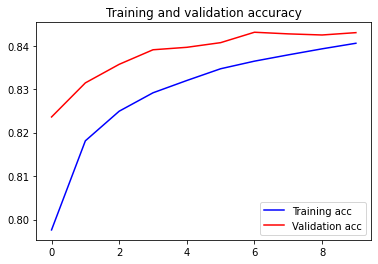

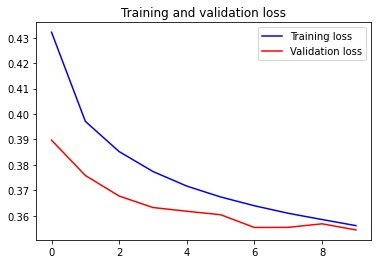

In [23]:
acc,  val_acc  = history.history['accuracy'], history.history['val_accuracy']
loss, val_loss = history.history['loss'], history.history['val_loss']
epochs = range(len(acc))

plt.plot(epochs, acc, 'b', label='Training acc')
plt.plot(epochs, val_acc, 'r', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'b', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

In [24]:
from sklearn.metrics import confusion_matrix, classification_report

def ConfusionMatrix(y_pred, y_test):
    # Compute and plot the Confusion matrix
    cf_matrix = confusion_matrix(y_test, y_pred)

    categories  = ['Negative','Positive']
    group_names = ['True Neg','False Pos', 'False Neg','True Pos']
    group_percentages = ['{0:.2%}'.format(value) for value in cf_matrix.flatten() / np.sum(cf_matrix)]

    labels = [f'{v1}\n{v2}' for v1, v2 in zip(group_names,group_percentages)]
    labels = np.asarray(labels).reshape(2,2)

    sns.heatmap(cf_matrix, annot = labels, cmap = 'Blues',fmt = '',
                xticklabels = categories, yticklabels = categories)

    plt.xlabel("Predicted values", fontdict = {'size':14}, labelpad = 10)
    plt.ylabel("Actual values"   , fontdict = {'size':14}, labelpad = 10)
    plt.title ("Confusion Matrix", fontdict = {'size':18}, pad = 20)

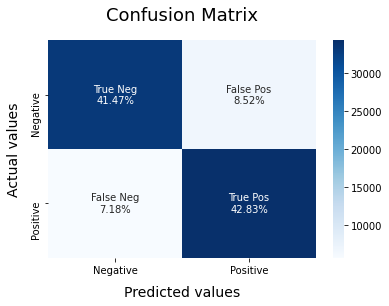

In [25]:
# Predicting on the Test dataset.
y_pred = training_model.predict(X_test)

# Converting prediction to reflect the sentiment predicted.
y_pred = np.where(y_pred>=0.5, 1, 0)

# Printing out the Evaluation metrics. 
ConfusionMatrix(y_pred, y_test)

In [26]:
# Print the evaluation metrics for the dataset.
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.85      0.83      0.84     39989
           1       0.83      0.86      0.85     40011

    accuracy                           0.84     80000
   macro avg       0.84      0.84      0.84     80000
weighted avg       0.84      0.84      0.84     80000



In [53]:
# Saving Word2Vec-Model
word2vec_model.wv.save('drive/My Drive/Model1/Word2Vec-twitter-100-dims')
word2vec_model.wv.save_word2vec_format('drive/My Drive/Model1/Word2Vec-twitter-100-dims-trainable')

# Saving the tokenizer
with open('drive/My Drive/Model1/Tokenizer.pickle', 'wb') as file:
    pickle.dump(tokenizer, file)

# Saving the TF-Model.
training_model.save('drive/My Drive/Model1/Twitter-Sentiment-BiLSTM.h5')

In [50]:
# Predicting

def decode_sentiment(score):
    label = None
    if score <= 0.45:
        label = 'Negative'
    elif score >= 0.55:
        label = 'Positive'
    else:
        label = 'Neutral'
    
    return label

In [47]:
def predict(text):
    x_test = pad_sequences(tokenizer.texts_to_sequences([text]), maxlen=input_length)
    score = training_model.predict([x_test])[0]
    
    label = decode_sentiment(score)

    return {"label": label, "score": float(score)}

In [48]:
predict('Vacation was amazing')

{'label': 'Positive', 'score': 0.9885326623916626}

In [67]:
predict('I have recovered from Covid19')

{'label': 'Negative', 'score': 0.003504897002130747}